#Solving the Travelling Salesman Problem using QAOA

*   Group members: Mariam Khaled and Ehan Sajjad
*   Mentor: Vanessa Dehn

## Introduction
## What is the Travelling Salesman Problem?
The Travelling Salesman Problem (TSP) is an NP-hard problem in combinatorial optimisation. It asks for the shortest route that visits each city exactly once and returns to the starting city. In the symmetric case where the distance between any two cities is the same regardless of the travelling direction, the TSP can be mathematically mapped as an undirected graph G with vertices V and edges E, i.e., G = (V, E). Then, we need to find the find the shortest possible Hamiltonian cycle in the graph, which is a sequence of edges that visits everynode once and returns to the start node.

In [ ]:
!pip install networkx

Classic solution

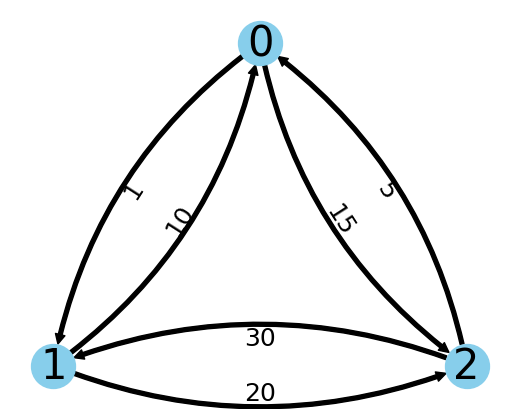

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(directed=True)

# Add nodes 0, 1, 2
G.add_nodes_from([0, 1, 2])

# Add all directed edges between the three nodes (no self-loops)
G.add_edge(0,1, weight=1)
G.add_edge(1,0, weight=10)
G.add_edge(0,2, weight=15)
G.add_edge(2,0, weight=5)
G.add_edge(1,2, weight=20)
G.add_edge(2,1, weight=30)

# Position for 3 nodes
pos = {
    0: [0.5, 1.0],
    1: [0.2, 0.0],
    2: [0.8, 0.0]
}

# LaTeX-style edge labels (symmetrical info shown together)
edge_labels = {
    (0, 1): '1\n\n10',
    (0, 2): '5\n\n15',
    (1, 2): '30\n\n20'
}

fig = plt.figure(1, figsize=(5, 4))
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos,
        connectionstyle='arc3, rad = 0.2', node_size=1000, arrowsize=14, arrowstyle='simple', font_size=30)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, bbox=dict(alpha=0))

plt.show()

##Bruteforce : the classical solution

In [ ]:
import networkx as nx
from itertools import permutations

def solve_tsp_bruteforce(graph: nx.DiGraph, start_node=0):
    nodes = list(graph.nodes)
    n = len(nodes)

    if start_node not in nodes:
        raise ValueError("Start node not in graph")

    min_cost = float('inf')
    min_path = None

    for perm in permutations(nodes):
        if perm[0] != start_node:
            continue

        cost = 0
        valid = True
        for i in range(n - 1):
            if graph.has_edge(perm[i], perm[i+1]):
                cost += graph[perm[i]][perm[i+1]]['weight']
            else:
                valid = False
                break
        # Return to start
        if valid and graph.has_edge(perm[-1], perm[0]):
            cost += graph[perm[-1]][perm[0]]['weight']
        else:
            valid = False

        if valid and cost < min_cost:
            min_cost = cost
            min_path = perm + (perm[0],)

    return min_cost, min_path

In [ ]:
# The classic code answer
cost, path = solve_tsp_bruteforce(G, start_node=0)
print("Minimum cost:", cost)
print("Path:", path)

Minimum cost: 26
Path: (0, 1, 2, 0)


Preparation for performing QAOA

In [ ]:
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install pylatexenc==2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=055723d06a0ef98a16b4605cf81e5abdabf351dea3e708b89ee07c728a72fdc3
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [ ]:
import networkx as nx
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit
from scipy.optimize import minimize
from qiskit.circuit import Parameter

##Preparation of equal superposition state
$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$
Can be prepared by applying Hadamard gates starting from an all-zero state as shown in the circuit below.

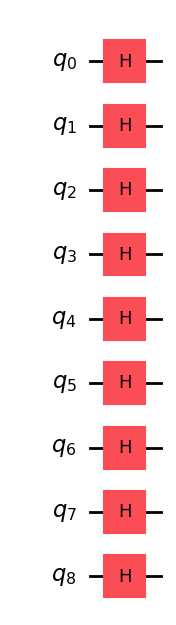

In [ ]:
n = len(G.nodes())
nqubits = n**2
qc = QuantumCircuit(nqubits)
for i in range(nqubits):
    qc.h(i)

qc.draw(output="mpl")

##Cost layer
The Cost Layer's Unitary operator is the following:
$$\hat{U}(\hat{H},\gamma) = e^{-i\gamma \hat{H}}$$

$$\hat{H}_{\text{cost}} = \frac{1}{4} \sum_{i,j,p} w_{i,j} \left(-\hat{Z}_{i,p} - Z_{j,(p+1)\mod n} + \hat{Z}_{i,p} \hat{Z}_{j,(p+1)\mod n} \right)$$

$$\hat{H}_{\text{constraint1}}=A\left(\sum_p \left( \frac{1}{2} \sum_{i < k} \hat{Z}_{i,p} \hat{Z}_{k,p} - \frac{n-2}{2} \sum_i \hat{Z}_{p,i} \right)\right)$$

$$\hat{H}_{\text{constraint2}} = A\left(\sum_i \left( \frac{1}{2} \sum_{p < k} \hat{Z}_{i,p} \hat{Z}_{i,k} - \frac{n-2}{2} \sum_i \hat{Z}_{i,p} \right)\right)$$

$$\hat{H}= \hat{H}_{\text{cost}}+\hat{H}_{\text{constraint1}}+\hat{H}_{\text{constraint2}}$$

$$\hat{H} = \frac{1}{4} \sum_{i,j,p} w_{i,j} \left(-\hat{Z}_{i,p} - \hat{Z}_{j,(p+1)\mod n} + \hat{Z}_{i,p} \hat{Z}_{j,(p+1)\mod n} \right) + A\left(\sum_p \left( \frac{1}{2} \sum_{i < k} \hat{Z}_{i,p} \hat{Z}_{k,p} - \frac{n-2}{2} \sum_i \hat{Z}_{p,i} \right)\right) + A\left(\sum_i \left( \frac{1}{2} \sum_{p < k} \hat{Z}_{i,p} \hat{Z}_{i,k} - \frac{n-2}{2} \sum_i \hat{Z}_{i,p} \right)\right)$$

###Objective (distance) Hamiltonian

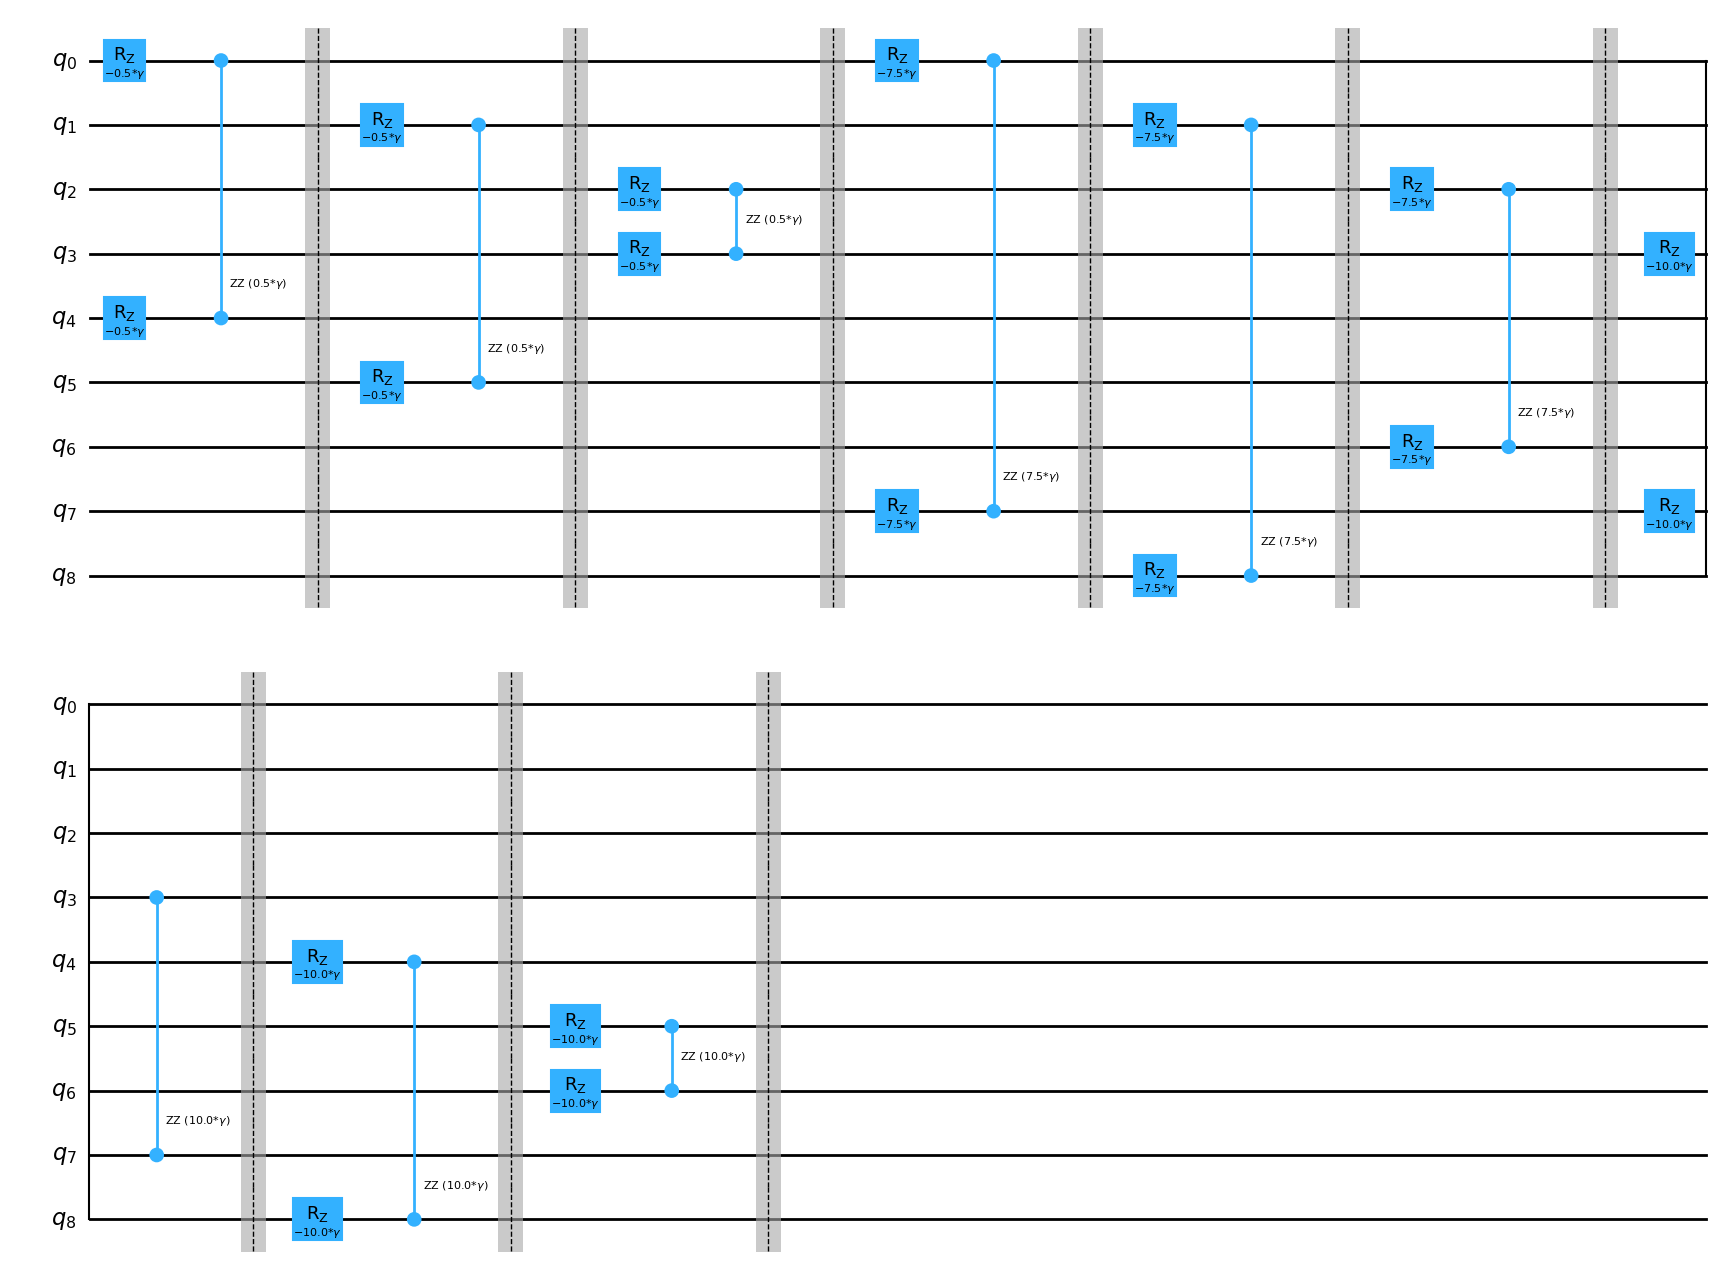

In [ ]:
gamma = Parameter("$\\gamma$")

qc_cost = QuantumCircuit(nqubits)

def q(time, city):
    return time * n + city


for i in range(n):
    for j in range(i+1, n):
      d = G[i][j]['weight']
      for k in range(n):
        qc_cost.rz(2 * gamma * (-d/4), q(i, k))
        qc_cost.rz(2 * gamma * (-d/4), q(j, (k+1)%n))
        qc_cost.rzz(2 * gamma * (d/4), q(i, k), q(j, (k+1)%n))
        qc_cost.barrier()

qc_cost.draw(output="mpl")

###Constraint term

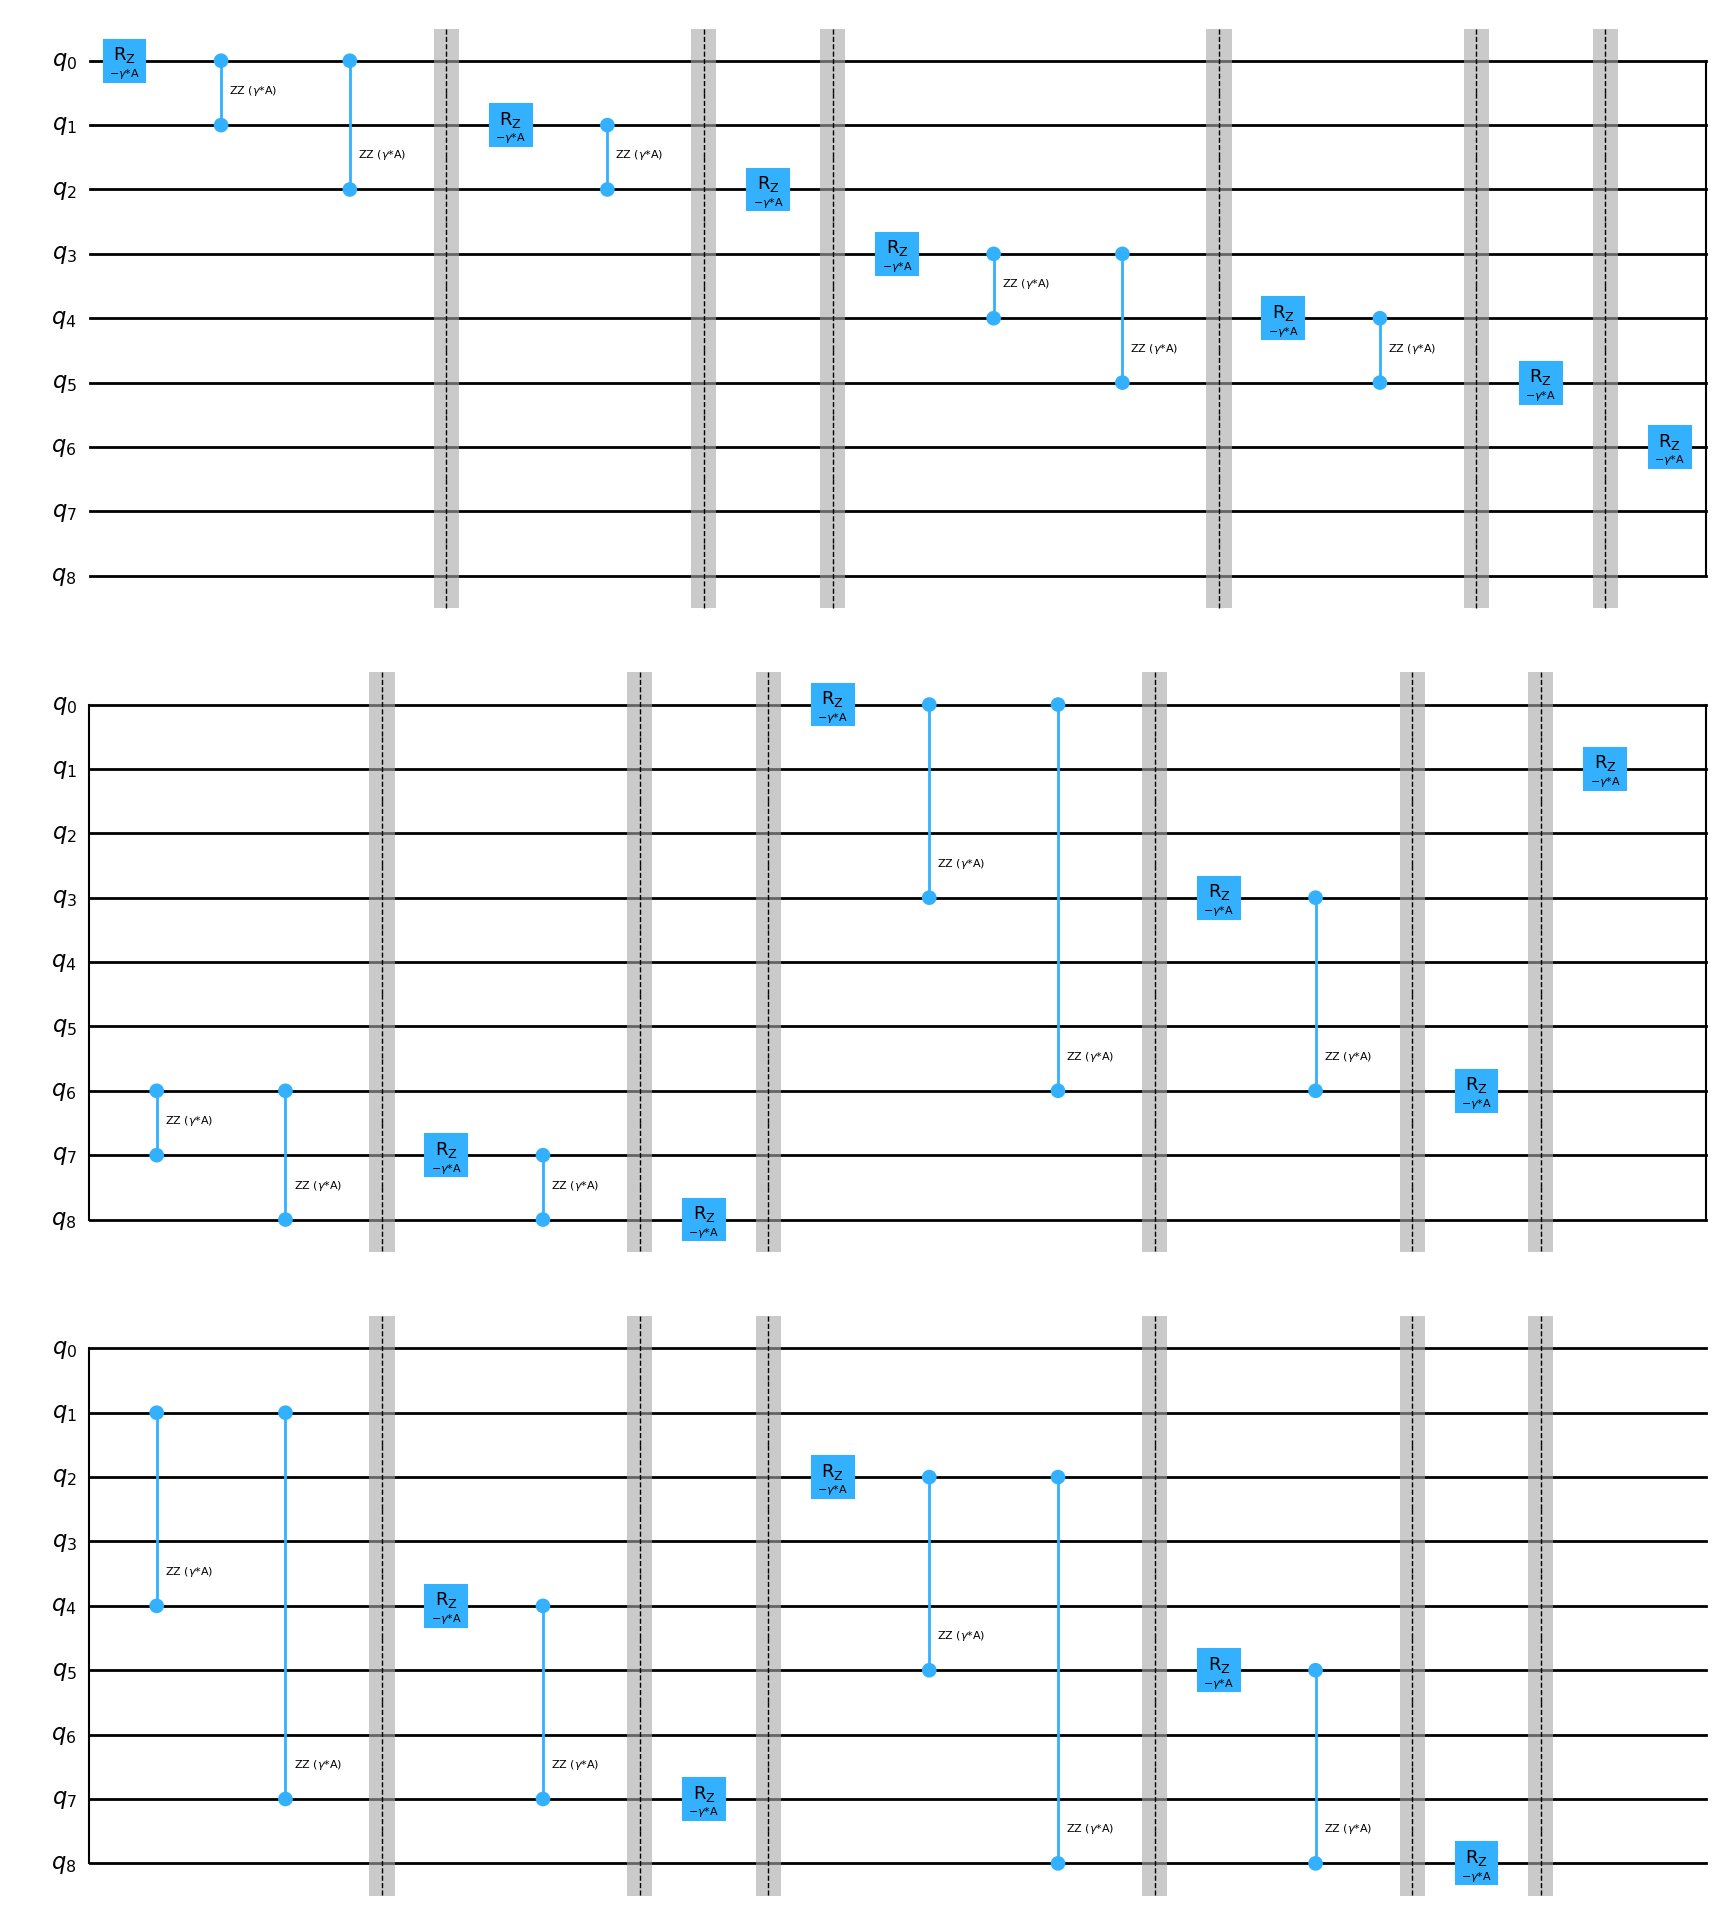

In [ ]:
a = Parameter("A")
qc_constraint = QuantumCircuit(nqubits)

#Row-wise constraints (penalty scaled by 'a')
for time in range(n):
  for city in range(n):
      qc_constraint.rz(2 * gamma * (-a * (n-2)/2), q(time, city))
      for other_city in range(city+1, n):
          qc_constraint.rzz(2 * gamma * (a * 1/2), q(time, city), q(time, other_city))
      qc_constraint.barrier()

#Column-wise constraints (penalty scaled by 'a')
for city in range(n):
  for time in range(n):
    qc_constraint.rz(2 * gamma * (-a * (n-2)/2), q(time, city))
    for other_time in range(time+1, n):
      qc_constraint.rzz(2 * gamma * (a * 1/2), q(time, city), q(other_time, city))
    qc_constraint.barrier()

qc_constraint.draw(output="mpl")

##Mixed layer
The Mixer Layer's Unitary operator is the following:
$$\hat{U}_M(\beta_i) = e^{-i\beta_i\hat{H}_M}$$
$$\hat{H}_M = \sum_{(i,j)}X_iX_j + Y_iY_j,$$

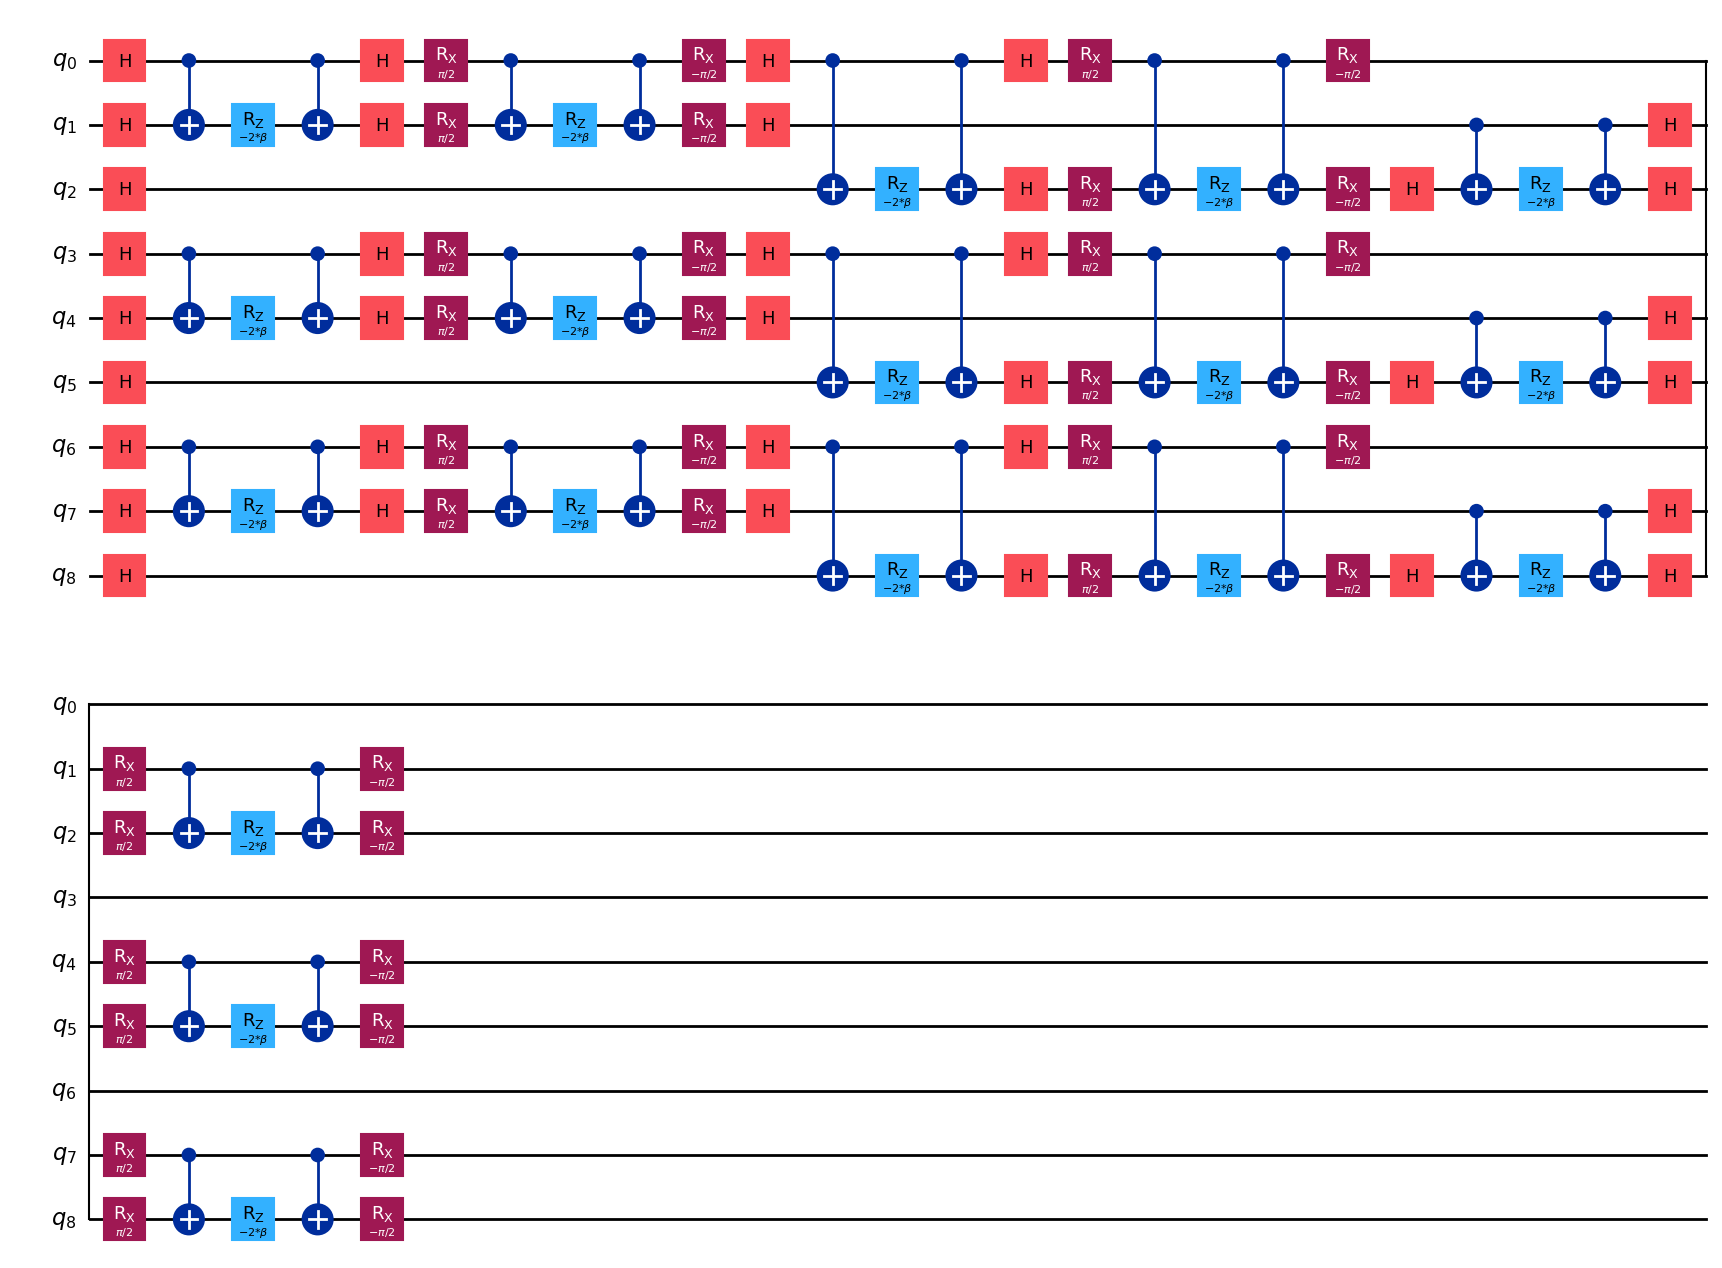

In [ ]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)

for time in range(n):
  for city1 in range(n):
    for city2 in range(city1 + 1, n):
      q1 = q(time, city1)
      q2 = q(time, city2)
      qc_mix.rxx(-2 * beta, q1, q2)
      qc_mix.ryy(-2 * beta, q1, q2)

for city in range(n):
  for time2 in range(time + 1, n):
    q1 = q(time, city)
    q2 = q(time2, city)
    qc_mix.rxx(-2 * beta, q1, q2)
    qc_mix.ryy(-2 * beta, q1, q2)

qc_mix.decompose().draw(output="mpl")

##The QAOA circuit

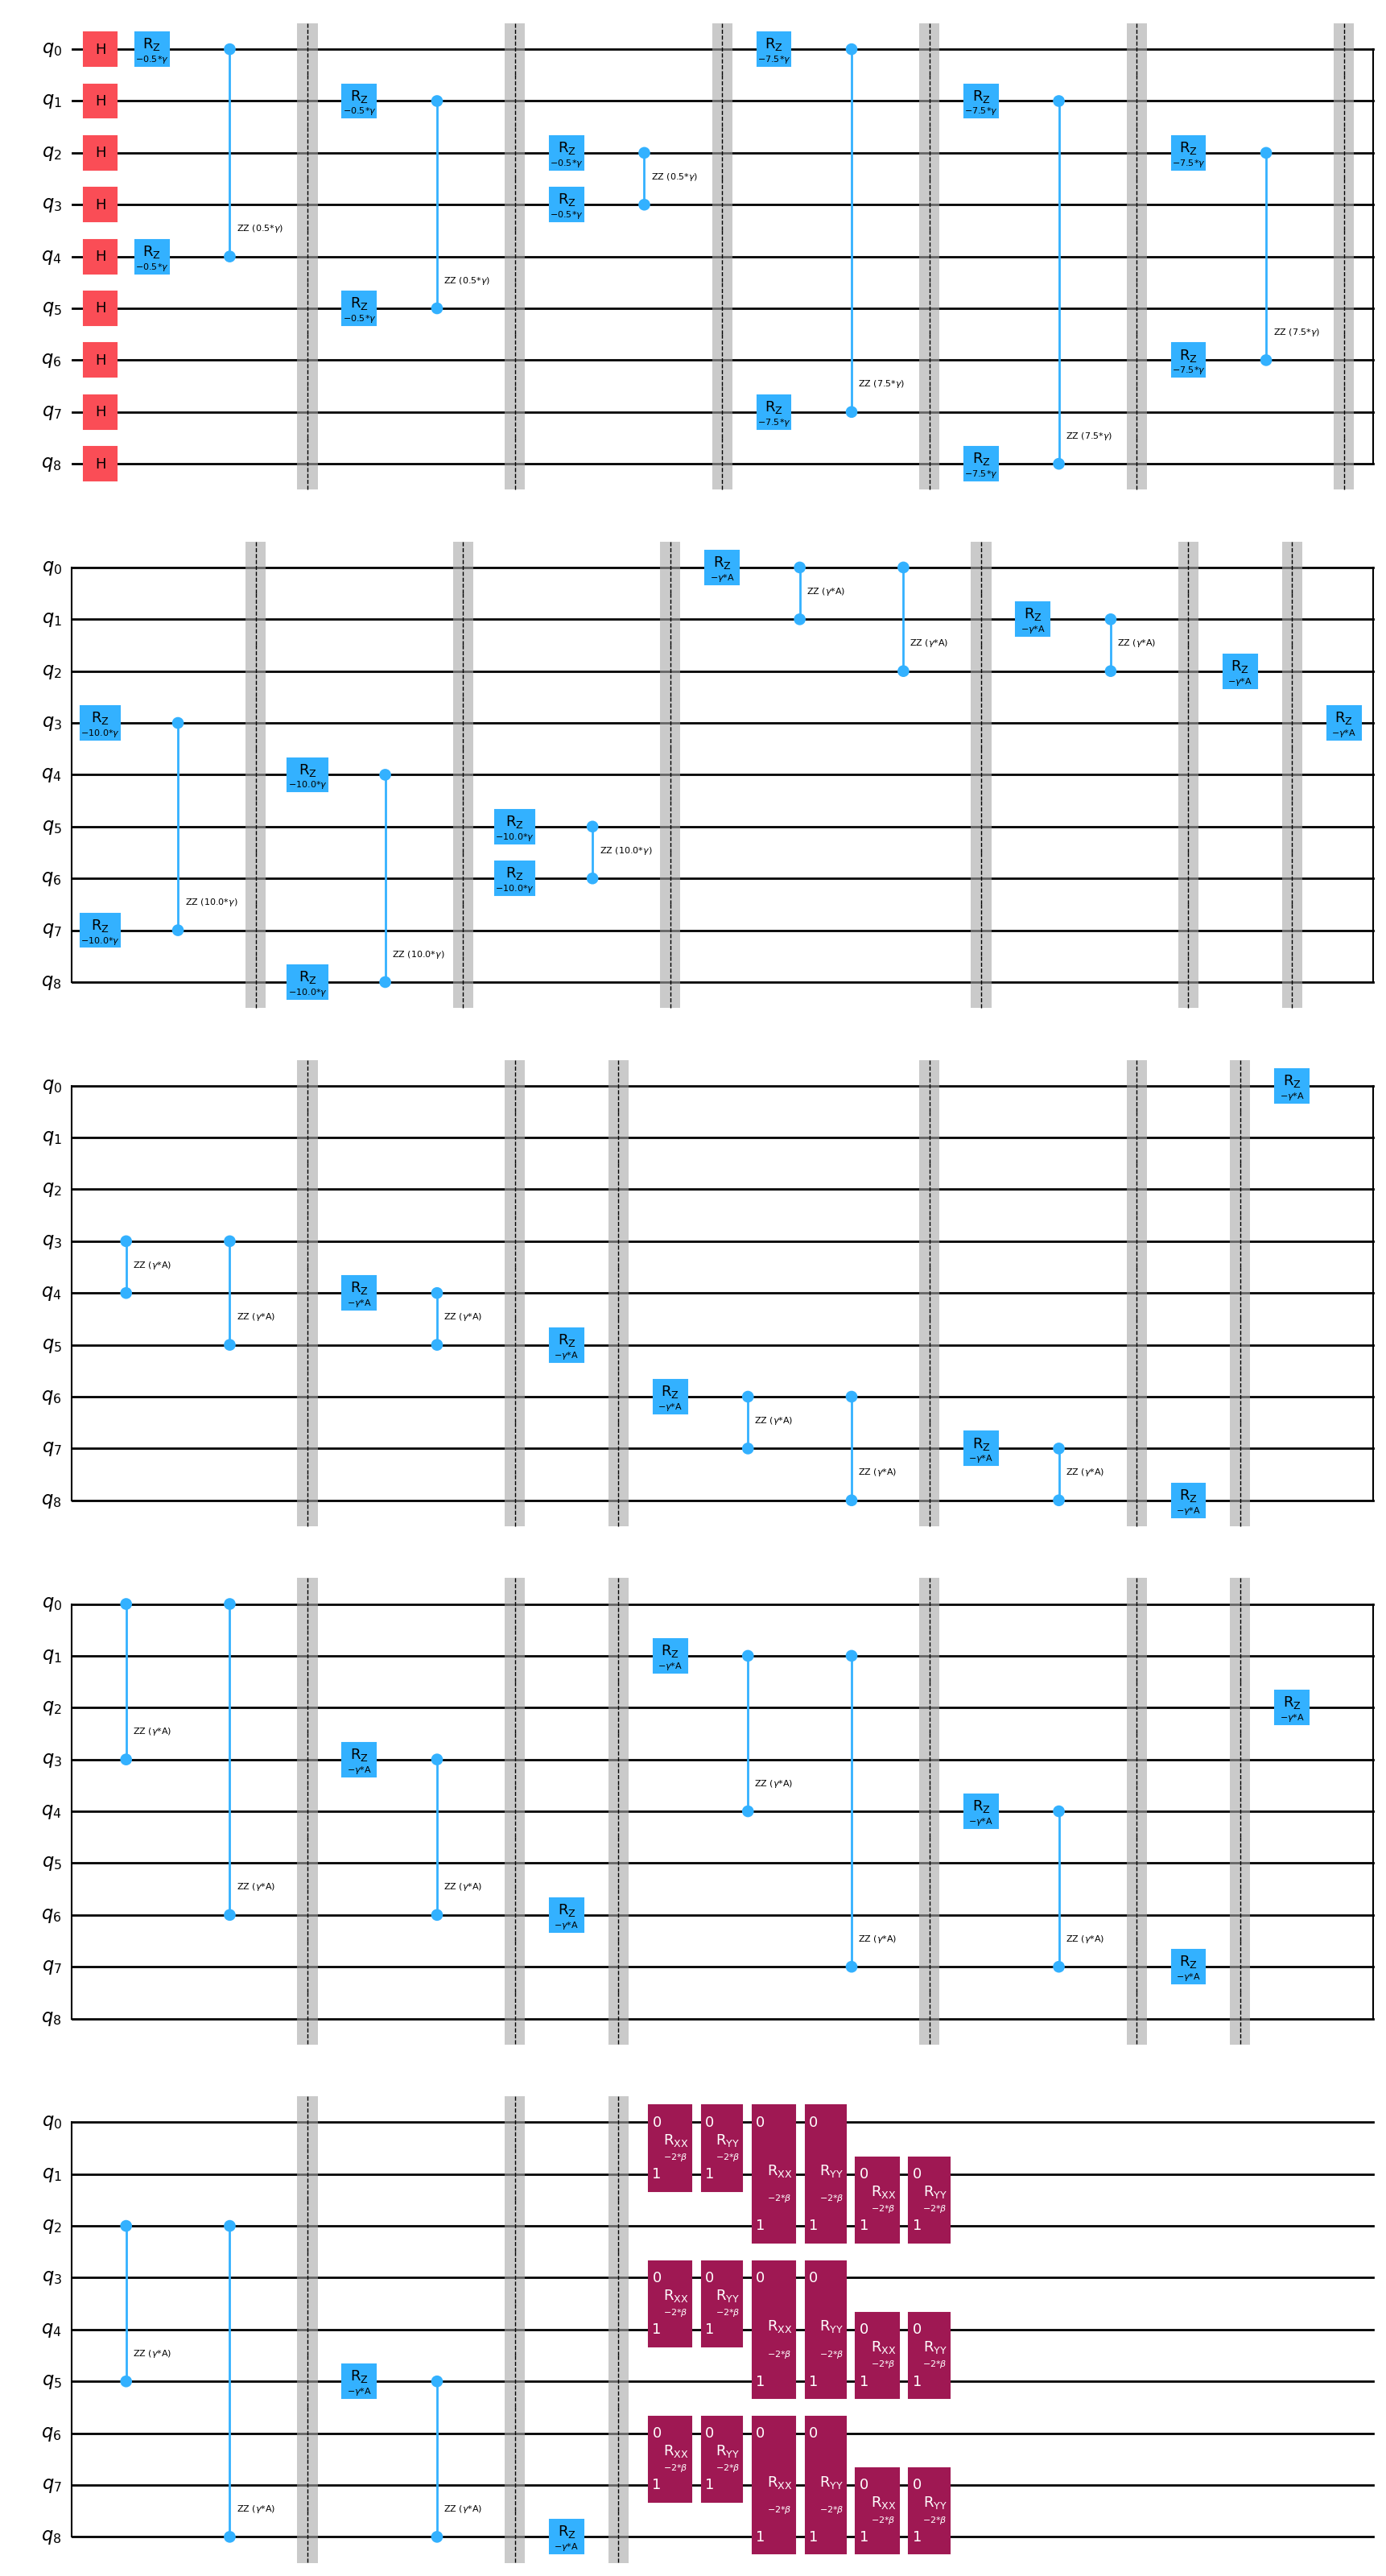

In [ ]:
qc_qaoa = QuantumCircuit(nqubits)
qc_qaoa.append(qc, range(nqubits))
qc_qaoa.append(qc_cost, range(nqubits))
qc_qaoa.append(qc_constraint, range(nqubits))
qc_qaoa.append(qc_mix, range(nqubits))

qc_qaoa.decompose().draw(output="mpl")

In [ ]:
# Helper Functions
def bitstr_to_tour(bit_string, n):
    matrix = np.array(list(bit_string), dtype=int).reshape(n, n)
    if not np.all(matrix.sum(axis=0) == 1) or not np.all(matrix.sum(axis=1) == 1):
        return None
    return list(np.argmax(matrix, axis=1))

def valid(tour, n):
    return tour is not None and len(tour) == n and len(set(tour)) == n

def TSP_obj(bit_string, graph):
    n = len(graph)
    tour = bitstr_to_tour(bit_string, n)
    if not valid(tour, n):
        return 1e18
    total_distance = 0
    for i in range(n):
        total_distance += graph[tour[i]][tour[(i + 1) % n]]['weight']
    return total_distance

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        bit_string = bit_string[::-1]
        obj = TSP_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg / sum_count



In [ ]:
# QAOA Circuit
def create_qaoa_circ(graph, theta,a_scaling=10):
    n = len(graph.nodes())
    nqubits = n**2
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    qc = QuantumCircuit(nqubits)
    qc.h(range(nqubits))
    qc.barrier()

    # Calculate penalty constant 'a' based on problem instance
    max_distance = max(graph[i][j]['weight'] for i in range(n) for j in range(i+1,n))
    a = a_scaling*max_distance * n**2

    def q(time, city):
        return time * n + city

    for layer_index in range(n_layers):
        #Objective (distance) Hamiltonian

        for i in range(n):
            for j in range(i+1, n):
                d = graph[i][j]['weight']
                for k in range(n):
                    qc.rz(2 * gamma[layer_index] * (-d/4), q(i, k))
                    qc.rz(2 * gamma[layer_index] * (-d/4), q(j, (k+1)%n))
                    qc.rzz(2 * gamma[layer_index] * (d/4), q(i, k), q(j, (k+1)%n))

        #Row-wise constraints (penalty scaled by 'a')
        for time in range(n):
            for city in range(n):
                qc.rz(2 * gamma[layer_index] * (-a * (n-2)/2), q(time, city))
                for other_city in range(city+1, n):
                    qc.rzz(2 * gamma[layer_index] * (a * 1/2), q(time, city), q(time, other_city))

        #Column-wise constraints (penalty scaled by 'a')
        for city in range(n):
            for time in range(n):
                qc.rz(2 * gamma[layer_index] * (-a * (n-2)/2), q(time, city))
                for other_time in range(time+1, n):
                    qc.rzz(2 * gamma[layer_index] * (a * 1/2), q(time, city), q(other_time, city))

        # Apply mixer once per layer
        for time in range(n):
          for city1 in range(n):
            for city2 in range(city1 + 1, n):
                q1 = q(time, city1)
                q2 = q(time, city2)
                qc.rxx(-2 * beta[layer_index], q1, q2)
                qc.ryy(-2 * beta[layer_index], q1, q2)

          for city in range(n):
            for time2 in range(time + 1, n):
                q1 = q(time, city)
                q2 = q(time2, city)
                qc.rxx(-2 * beta[layer_index], q1, q2)
                qc.ryy(-2 * beta[layer_index], q1, q2)



    qc.measure_all()
    return qc

In [ ]:
# ==================== Expectation Function ====================
def get_expectation(graph, shots=8192):
    backend = Aer.get_backend('qasm_simulator')

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        result = backend.run(qc, shots=shots, seed_simulator=42).result()
        counts = result.get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

# ==================== Run QAOA ====================
def run_qaoa(graph, p=35, shots=8192):
    expectation = get_expectation(graph, shots=shots)

    beta = [np.pi / 2 * (i + 1) / (p + 1) for i in range(p)]
    gamma = [np.pi * (i + 1) / (p + 1) for i in range(p)]

    init = gamma+beta
    res = minimize(expectation, init, method='COBYLA')

    # Use the best theta found
    qc = create_qaoa_circ(graph, res.x)
    backend = Aer.get_backend('qasm_simulator')
    counts = backend.run(qc, shots=shots).result().get_counts()
    # Get the most frequent result
    most_common_bitstring = max(counts, key=counts.get)
    most_common_count = counts[most_common_bitstring]

    return most_common_bitstring,counts



In [ ]:
bitstring,count = run_qaoa(G)
print("The best tour",bitstr_to_tour(bitstring, n))
print("The shortest path",TSP_obj(bitstring, G))

The best tour [np.int64(2), np.int64(0), np.int64(1)]
The shortest path 26


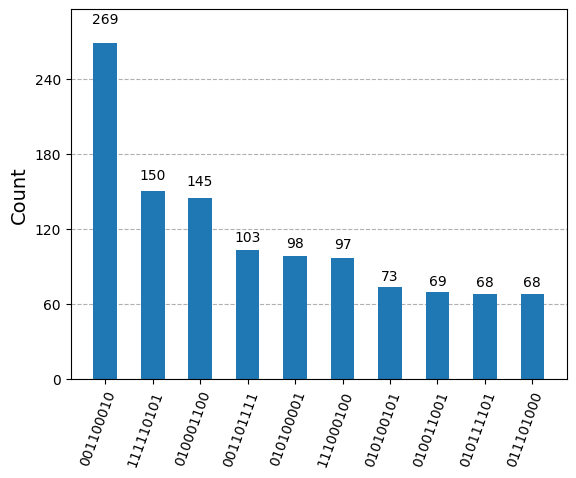

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(count, number_to_keep=10, sort="value_desc")

##References:

1. **Original QAOA Paper**:  
   Farhi, E., Goldstone, J., & Gutmann, S. (2014). A Quantum Approximate Optimization Algorithm. *arXiv preprint* [arXiv:1411.4028](https://arxiv.org/abs/1411.4028).  
